# Book Recommendation System - RBM
We don't explicitly need to specify a gpu device.
It will be picked up on it's own if CUDA is correctly installed.
Note that the tensorflow-gpu and cuda version should be compatible.
I am using tf - 1.4.1 with cuda - 8.0. If you're are using cuda 0.9 or later,
you will need a different version of tensorflow-gpu

We are going to use Restricted Boltzmann Machines for this project. They have
only two layers in the network (one hidden and one visible). The hidden layer
has the ability to learn latent features from the input and this helps in
categorizing the input into different classes. For example, if the input is the
user preference (in binary - likes or didn't like) for 6 books and the hidden
layer has 2 units, the latent features learnt could be the categories of books -
"Crime" and "Romance". This is then used to reconstruct user input which helps
in creating a score about the user choice. This score is finally used to
recommend the books.

In [27]:
# importing required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
plt.switch_backend('agg')

# Loading the books and ratings
#n = 500
# loading every 500th line as the dataset is too large
# and tensorflow fails to create a tensor of such a large size
#ratings = pd.read_csv("data/ratings.csv", skiprows=lambda i: i % n != 0)
ratings = pd.read_csv('data/ratings.csv')
to_read = pd.read_csv('data/to_read.csv')
books = pd.read_csv('data/books.csv')

temp = ratings.sort_values(by=['user_id'], ascending=True)
ratings = temp.iloc[:200000, :]

# creating a new column with indexes to ease the process of creating our training data
ratings = ratings.reset_index(drop=True)
ratings['List Index'] = ratings.index
readers_group = ratings.groupby("user_id")

total = []
#train = np.zeros((readers_group.shape[0], len(ratings)))
#usedReaders = 500
for readerID, curReader in readers_group:
    #temp = [0] * len(ratings)
    temp = np.zeros(len(ratings))

    for num, book in curReader.iterrows():
        temp[book['List Index']] = book['rating'] / 5.0

    total.append(temp)
    # this code chunk can be used if we want to stop after
    # a specific number of readers from our data
    '''
    if usedReaders == 0:
        break
    usedReaders -= 1
    print("readers remaining: ", usedReaders)
    '''
# Not a good idea to print train as it cannot be held into memory all at once.
# print(train)

random.shuffle(total)
print("total size of the data is: {0}".format(len(total)))

train = total[:1500]
valid = total[1500:]
print("size of the training data is: {0}".format(len(train)))
print("size of the validation data is: {0}".format(len(valid)))

print("Setting the models Parameters")
hiddenUnits = 64
visibleUnits = len(ratings)

vb = tf.placeholder(tf.float32, [visibleUnits])  # Number of unique movies
# Number of features were going to learn
hb = tf.placeholder(tf.float32, [hiddenUnits])
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix

print("Phase 1: Input Processing")
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Visible layer activation
# Gibb's Sampling
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

print("Phase 2: Reconstruction")
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) +
                    vb)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

print("Setting RBM Training Parameters")
# Learning rate
alpha = 0.6

print("Creating the gradients")
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

""" Initialize our Variables with Zeroes using Numpy Library """
# Current weight
cur_w = np.random.normal(loc=0, scale=0.01, size=[visibleUnits, hiddenUnits])

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)

print("Running the session")
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

def free_energy(v_sample, W, vb, hb):
    ''' Function to compute the free energy '''
    wx_b = np.dot(v_sample, W) + hb
    vbias_term = np.dot(v_sample, vb)
    hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis = 1)
    return -hidden_term - vbias_term


# Training RBM with 60 Epochs, with Each Epoch using batch size of 100.
# After training print out the error with epoch number.
print("Starting the training process")
epochs = 60
batchsize = 100
errors = []
energy_train = []
energy_valid = []
for i in range(epochs):
    for start, end in zip(range(0, len(train), batchsize), range(batchsize, len(train), batchsize)):
        batch = train[start:end]
        cur_w = sess.run(update_w, feed_dict={
                         v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={
                          v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={
                          v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb

    energy_train.append(np.mean(free_energy(train, cur_w, cur_vb, cur_hb)))
    #print("Epoch: {0}, free energy: {1}".format(i, energy_train[i]))
    energy_valid.append(np.mean(free_energy(valid, cur_w, cur_vb, cur_hb)))

    errors.append(sess.run(err_sum, feed_dict={
                  v0: train, W: cur_w, vb: cur_vb, hb: cur_hb}))
    if i % 10 == 0:
        print("Error in epoch {0} is: {1}".format(i, errors[i]))


# This is the input that we need to provide manually, that is the user number
user = 22
inputUser = [train[user]]

# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

# Creating recommendation score for books in our data
ratings["Recommendation Score"] = rec[0]

""" Recommend User what books he has not read yet """
# Find the mock user's user_id from the data
cur_user_id = ratings.iloc[user]['user_id']

# Find all books the mock user has read before
read_books = ratings[ratings['user_id'] == cur_user_id]['book_id']
read_books

# converting the pandas series object into a list
read_books_id = read_books.tolist()

# getting the book names and authors for the books already read by the user
read_books_names = []
read_books_authors = []
for book in read_books_id:
    read_books_names.append(
        books[books['book_id'] == book]['original_title'].tolist()[0])
    read_books_authors.append(
        books[books['book_id'] == book]['authors'].tolist()[0])

# Find all books the mock user has 'not' read before using the to_read data
unread_books = to_read[to_read['user_id'] == cur_user_id]['book_id']
unread_books_id = unread_books.tolist()
unread_books_id

# extract the ratings of all the unread books from ratings dataframe
unread_with_score = ratings[ratings['book_id'].isin(unread_books_id)]
unread_with_score

# grouping the unread data on book id and taking the mean of the recommendation scores for each book_id
grouped_unread = unread_with_score.groupby('book_id', as_index=False)[
    'Recommendation Score'].mean()
grouped_unread

# getting the names and authors of the unread books
unread_books_names = []
unread_books_authors = []
unread_books_scores = []
for book in grouped_unread['book_id']:
    unread_books_names.append(
        books[books['book_id'] == book]['original_title'].tolist()[0])
    unread_books_authors.append(
        books[books['book_id'] == book]['authors'].tolist()[0])
    unread_books_scores.append(
        grouped_unread[grouped_unread['book_id'] == book]['Recommendation Score'].tolist()[0])

# creating a data frame for unread books with their names, authors and recommendation scores
unread_books_with_scores = pd.DataFrame({
    'book_name': unread_books_names,
    'book_authors': unread_books_authors,
    'score': unread_books_scores
})

# creating a data frame for read books with the names and authors
read_books_with_names = pd.DataFrame({
    'book_name': read_books_names,
    'book_authors': read_books_authors
})

# sort the result in descending order of the recommendation score
sorted_result = unread_books_with_scores.sort_values(
    by='score', ascending=False)

# exporting the read and unread books  with scores to csv files
read_books_with_names.to_csv('results/read_books_with_names.csv')
sorted_result.to_csv('results/unread_books_with_scores.csv')


total size of the data is: 1731
size of the training data is: 1500
size of the validation data is: 231
Setting the models Parameters
Phase 1: Input Processing
Phase 2: Reconstruction
Setting RBM Training Parameters
Creating the gradients
Running the session
Starting the training process
Error in epoch 0 is: 0.11417695879936218
Error in epoch 10 is: 0.01152096875011921
Error in epoch 20 is: 0.00628060894086957
Error in epoch 30 is: 0.004433622118085623
Error in epoch 40 is: 0.0034862521570175886
Error in epoch 50 is: 0.0029167060274630785


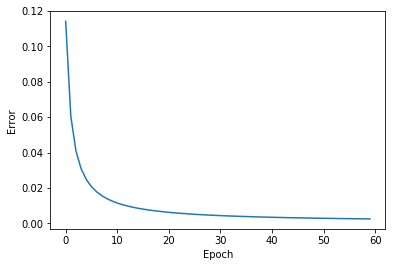

In [28]:
%matplotlib inline

plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.savefig("error.png")
plt.show()

## Deciding optimal number of epochs
Plotting the average free energy for training and the validation dataset ran with 200 epochs to select the optimal number of epochs.

If the model is not overfitting at all, the average free energy should be about the same on training and validation data. As the model starts to overfit the average free energy of the validation data will rise relative to the average
free energy of the training data and this gap represents the amount of overfitting. So we can determine the number of epochs to run the training for using this approach.

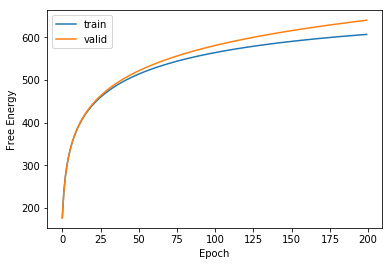

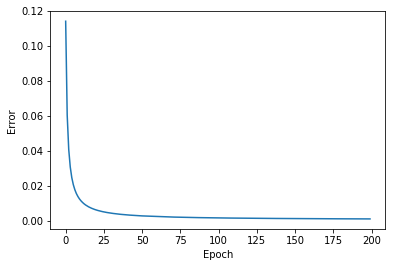

In [24]:
fig, ax = plt.subplots()
ax.plot(energy_train, label='train')
ax.plot(energy_valid, label='valid')
leg = ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Free Energy")
plt.savefig("free_energy.png")
plt.show()
